# Importing Modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.special import expit

# Importing The Dataset

In [ ]:
df = pd.read_csv('diabetes2.csv')

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Splitting Dataset Into Train,Validation and Test Sets

In [ ]:
def train_val_test_split(data,val_size=0.2,test_size=0.1,random_state=0):
  """
  Train Valdiation Test split implemented from scratch. Takes the dataset,
  val_size, test_size and random_state as parameters and returns the train,
  validation and test sets.

  Calculates a random index from the dataset and adds it to the validation set 
  and removes it from the dataset.Process continued till validation set length 
  is less than val_size. Same process is followed for the test set.
  """
  
  random.seed(random_state)
  test = []
  val = []
  val_size = len(data)*val_size
  test_size = len(data)*test_size
  train = data.copy()

  while(test_size>len(test)):
    index = random.randrange(len(train))
    test.append(train.iloc[index,:].values)
    train.drop(index,axis=0,inplace=True)
    train.reset_index(drop=True,inplace=True)

  while(val_size>len(val)):
    index = random.randrange(len(train))
    val.append(train.iloc[index,:].values)
    train.drop(index,axis=0,inplace=True)
    train.reset_index(drop=True,inplace=True)

  test = pd.DataFrame(test)
  val = pd.DataFrame(val)
  return train,val,test

In [ ]:
df_train, df_val, df_test = train_val_test_split(df)

# Splitting Into X and y values

In [ ]:
X_train = df_train.iloc[:,:-1].values
y_train = df_train.iloc[:,-1].values
y_train = y_train.reshape(len(y_train),1)

X_val = df_val.iloc[:,:-1].values
y_val = df_val.iloc[:,-1].values
y_val = y_val.reshape(len(y_val),1)

X_test = df_test.iloc[:,:-1].values
y_test = df_test.iloc[:,-1].values
y_test = y_test.reshape(len(y_test),1)

In [ ]:
print(df.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(768, 9)
(537, 8)
(537, 1)
(154, 8)
(154, 1)
(77, 8)
(77, 1)


# Feature Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
standard_scaler_X = MinMaxScaler()
X_train = standard_scaler_X.fit_transform(X_train)
X_val = standard_scaler_X.transform(X_val)
X_test = standard_scaler_X.transform(X_test)

# Classification Metrics Class

In [ ]:
class ClassificationMetrics:
  """
  Class for calculating classification metrics-Confusion Matrix, Accuracy, Recall,
  ,Precision and F1Score
  """

  def __init__(self,y_test,y_pred):
    """
    Calculate the true negative, true postive, false negative and false postive
    values using y_pred and y_test
    """
    self.tn = 0
    self.tp = 0
    self.fp = 0
    self.fn = 0

    for i in range(len(y_test)):
      if y_test[i]==y_pred[i]:
        if y_test[i]:
          self.tp+=1
        else:
          self.tn+=1
      else:
        if y_test[i]:
          self.fn+=1
        else:
          self.fp+=1

  def confusion_matrix(self):
    """
    returns the confusion matrix in the form
    [
      [True Positive   False Positive]
      [False Negative  True Negative ]
    ]
    """
    return np.matrix([[self.tp,self.fp],[self.fn,self.tn]])

  def accuracy(self):
    """
    returns the accuracy given by (TP + TN)/(TP+TN+FP+FN)
    """
    try:
      return (self.tp+self.tn)/(self.tp+self.tn+self.fp+self.fn)
    except ZeroDivisionError:
      return 0.0

  def precision(self):
    """
    returns the precision given by (TP)/(TP+FP)
    """
    try:
      return self.tp/(self.tp+self.fp)
    except ZeroDivisionError:
      return 0.0

  def recall(self):
    """
    returns the recall given by TP/(TP+FN)
    """
    try:
      return self.tp/(self.tp+self.fn)
    except ZeroDivisionError:
      return 0.0

  def f1_score(self):
    """
    returns the f1_score given by 2*TP/ (2* TP + FP + FN)
    """
    try:
      return 2*self.tp/(2*self.tp+self.fp+self.fn)
    except ZeroDivisionError:
      return 0.0

# BGD Logistic Regression

In [ ]:
class BGDLogisticRegression:
  """
  Logistic Regression Implemented using Batch Gradient Descent
  """

  def __init__(self,alpha,limit):
    self.alpha = alpha
    self.limit = limit
    self.bias = 0
    self.train_loss = [0]*self.limit
    self.val_loss = [0]*self.limit

  def sigmoid(self,X):
    """
    returns values in the range 0 and 1
    """
    z = np.dot(X,self.theta) + self.bias
    return expit(z)

  def cost_function(self,y_true,y_pred,m):
    """
    Cost function for calculating the loss
    """
    return -np.sum((y_true*np.log(y_pred)) + ((1-y_true)*np.log(1-y_pred)))/m

  def fit(self,X,y,X_val,y_val):
    m = len(y)
    self.theta = np.zeros((X.shape[1],1))

    for i in range(self.limit):
      y_predicted = self.sigmoid(X)
      y_predicted_val = self.sigmoid(X_val)

      # calculate loss using cost function
      train_cost = self.cost_function(y,y_predicted,m)
      val_cost = self.cost_function(y_val,y_predicted_val,m)

      self.train_loss[i] = train_cost
      self.val_loss[i] = val_cost

      # update theta and bias 
      self.theta = self.theta - self.alpha* (np.dot(X.T,y_predicted-y)*2/m)
      self.bias = self.bias - self.alpha* (np.sum(y_predicted-y)*2/m)

  def plot(self):
    plt.plot(list(range(self.limit)),self.train_loss)
    plt.title("Training Loss v/s Iterations For Alpha = "+str(self.alpha))
    plt.show()

    plt.plot(list(range(self.limit)),self.val_loss)
    plt.title("Validation Loss v/s Iterations For Alpha = "+str(self.alpha))
    plt.show()

  def predict(self,X_test):
    """
    Classifying by applying the sigmoid function, for values greater than 0.5,
    we get 1 and for less <= 0.5 we get 0
    """
    return self.sigmoid(X_test) > 0.5

# Loss v/s Iteration Plots Using BGD

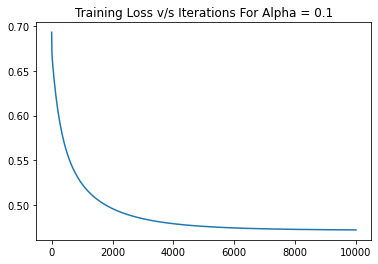

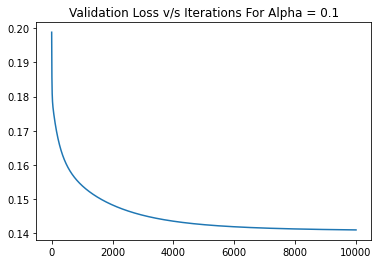



Alpha: 0.1, Iterations: 10000

For Validation Data
Accuracy:  0.7727272727272727
Precision:  0.5869565217391305
Recall:  0.627906976744186
F1 Score:  0.6067415730337079
Confusion Matrix
 [[27 19]
 [16 92]]


For Training Data
Accuracy:  0.7922077922077922
Precision:  0.7777777777777778
Recall:  0.5384615384615384
F1 Score:  0.6363636363636364
Confusion Matrix
 [[14  4]
 [12 47]]


In [ ]:
bgd = BGDLogisticRegression(0.1,10000)
bgd.fit(X_train,y_train,X_val,y_val)
bgd.plot()

print("\n\nAlpha: 0.1, Iterations: 10000\n")
print("For Validation Data")
y_pred_val_bgd = bgd.predict(X_val)
metrics = ClassificationMetrics(y_val,y_pred_val_bgd)
print("Accuracy: ",metrics.accuracy())
print("Precision: ",metrics.precision())
print("Recall: ",metrics.recall())
print("F1 Score: ",metrics.f1_score())
print("Confusion Matrix\n",metrics.confusion_matrix())


y_pred_test_bgd = bgd.predict(X_test)
metrics = ClassificationMetrics(y_test,y_pred_test_bgd)

print("\n\nFor Training Data")
print("Accuracy: ",metrics.accuracy())
print("Precision: ",metrics.precision())
print("Recall: ",metrics.recall())
print("F1 Score: ",metrics.f1_score())
print("Confusion Matrix\n",metrics.confusion_matrix())

# Re-Running On Different Learning Rates

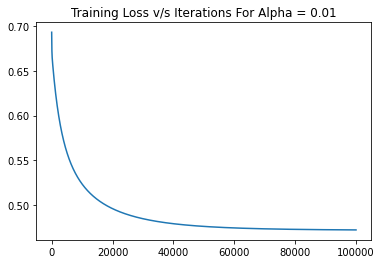

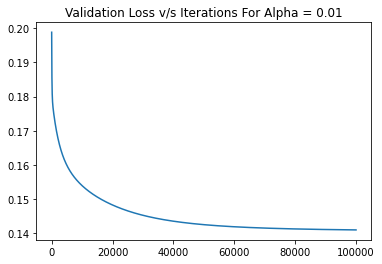



Alpha: 0.01, Iterations: 100000

For Validation Data
Accuracy:  0.7727272727272727
Precision:  0.5869565217391305
Recall:  0.627906976744186
F1 Score:  0.6067415730337079
Confusion Matrix
 [[27 19]
 [16 92]]


For Testing Data
Accuracy:  0.7922077922077922
Precision:  0.7777777777777778
Recall:  0.5384615384615384
F1 Score:  0.6363636363636364
Confusion Matrix
 [[14  4]
 [12 47]]


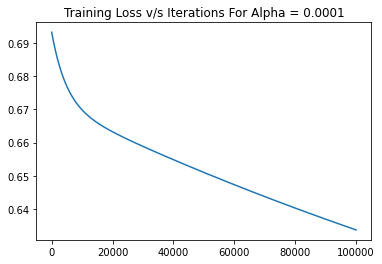

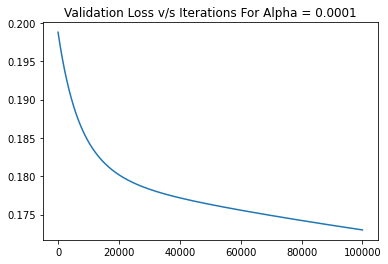



Alpha: 0.0001, Iterations: 100000

For Validation Data
Accuracy:  0.7207792207792207
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
Confusion Matrix
 [[  0   0]
 [ 43 111]]


For Testing Data
Accuracy:  0.6623376623376623
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
Confusion Matrix
 [[ 0  0]
 [26 51]]


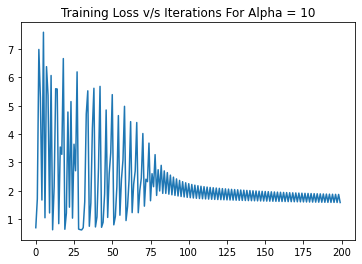

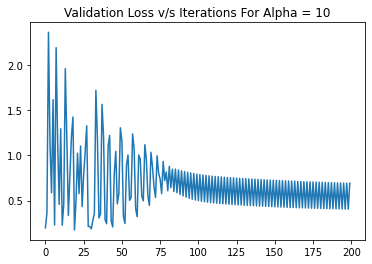



Alpha: 10, Iterations: 200

For Validation Data
Accuracy:  0.7532467532467533
Precision:  0.7777777777777778
Recall:  0.16279069767441862
F1 Score:  0.2692307692307692
Confusion Matrix
 [[  7   2]
 [ 36 109]]


For Testing Data
Accuracy:  0.6623376623376623
Precision:  0.5
Recall:  0.07692307692307693
F1 Score:  0.13333333333333333
Confusion Matrix
 [[ 2  2]
 [24 49]]


In [ ]:
alpha = [0.01,0.0001,10]
iterations = [100000,100000,200]

for i in range(3):
  bgd = BGDLogisticRegression(alpha[i],iterations[i])
  bgd.fit(X_train,y_train,X_val,y_val)
  bgd.plot()

  print("\n\nAlpha: "+str(alpha[i])+", Iterations: "+str(iterations[i])+"\n")
  print("For Validation Data")
  y_pred_val_bgd = bgd.predict(X_val)
  metrics = ClassificationMetrics(y_val,y_pred_val_bgd)
  print("Accuracy: ",metrics.accuracy())
  print("Precision: ",metrics.precision())
  print("Recall: ",metrics.recall())
  print("F1 Score: ",metrics.f1_score())
  print("Confusion Matrix\n",metrics.confusion_matrix())


  y_pred_test_bgd = bgd.predict(X_test)
  metrics = ClassificationMetrics(y_test,y_pred_test_bgd)

  print("\n\nFor Testing Data")
  print("Accuracy: ",metrics.accuracy())
  print("Precision: ",metrics.precision())
  print("Recall: ",metrics.recall())
  print("F1 Score: ",metrics.f1_score())
  print("Confusion Matrix\n",metrics.confusion_matrix())

# SGD Logistic Regression Class

In [ ]:
class SGDLogisticRegression:
  """
  Logistic Regression Implementation using Stochastic Gradient Descent
  """

  def __init__(self,alpha,limit):
    self.bias = 0
    self.alpha = alpha
    self.limit = limit
    self.train_loss = [0]*self.limit
    self.val_loss = [0]*self.limit

  def sigmoid(self,X):
    """
    returns values in the range 0 and 1
    """
    z = np.dot(X,self.theta.T)+self.bias
    return expit(-z)
    # return 1.0/(1+n/p.exp(-z))

  def cost_function(self,y_true,y_pred,m):
    """
    Cost function for calculating the loss
    """
    return -np.sum((y_true*np.log(y_pred+1e-5)) + ((1-y_true)*np.log(1-y_pred+1e-5)))/m

  def fit(self,X,y,X_val,y_val):
    self.theta = np.zeros_like(X[0],dtype=np.float128)
    n = len(X)

    for j in range(self.limit):
      #update theta and bias for each value in y
      for i in range(n):
        self.theta =self.theta-self.alpha*X[i]*(y[i]-self.sigmoid(X[i]))
        self.bias =self.bias-self.alpha*(y[i]-self.sigmoid(X[i]))
      
      #calculate the training and validation loss
      self.train_loss[j] = self.cost_function(y,self.sigmoid(X),n)
      self.val_loss[j] = self.cost_function(y_val,self.sigmoid(X_val),n)

  def plot(self):
    """
    Function for plotting the Training and Validation loss v/s Iterations
    """
    plt.plot(list(range(self.limit)),self.train_loss)
    plt.title("Training Loss v/s Iterations For Alpha = "+str(self.alpha))
    plt.show()

    plt.plot(list(range(self.limit)),self.val_loss)
    plt.title("Validation Loss v/s Iterations For Alpha = "+str(self.alpha))
    plt.show()

  def predict(self,X):
    """
    Classifying by applying the sigmoid function, for values greater than 0.5,
    we get 1 and for less <= 0.5 we get 0
    """
    return self.sigmoid(X) > 0.5

# Loss v/s Iteration Plots Using SGD

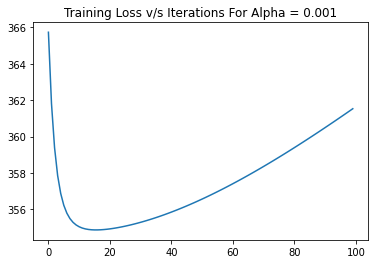

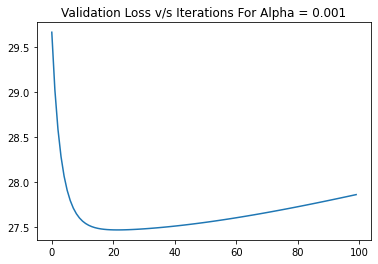



Alpha: 0.001 Iterations: 100

For Validation Data
Accuracy:  0.7337662337662337
Precision:  0.6
Recall:  0.13953488372093023
F1 Score:  0.22641509433962265
Confusion Matrix
 [[  6   4]
 [ 37 107]]


For Testing Data
Accuracy:  0.6883116883116883
Precision:  0.75
Recall:  0.11538461538461539
F1 Score:  0.2
Confusion Matrix
 [[ 3  1]
 [23 50]]


In [ ]:
sgd = SGDLogisticRegression(0.001,100)
sgd.fit(X_train,y_train,X_val,y_val)
sgd.plot()

print("\n\nAlpha: 0.001 Iterations: 100\n")
print("For Validation Data")
y_pred_val_sgd = sgd.predict(X_val)
metrics = ClassificationMetrics(y_val,y_pred_val_sgd)
print("Accuracy: ",metrics.accuracy())
print("Precision: ",metrics.precision())
print("Recall: ",metrics.recall())
print("F1 Score: ",metrics.f1_score())
print("Confusion Matrix\n",metrics.confusion_matrix())


y_pred_test_sgd = sgd.predict(X_test)
metrics = ClassificationMetrics(y_test,y_pred_test_sgd)

print("\n\nFor Testing Data")
print("Accuracy: ",metrics.accuracy())
print("Precision: ",metrics.precision())
print("Recall: ",metrics.recall())
print("F1 Score: ",metrics.f1_score())
print("Confusion Matrix\n",metrics.confusion_matrix())

# Re-Running On Different Learning Rates

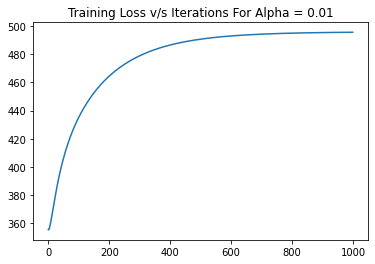

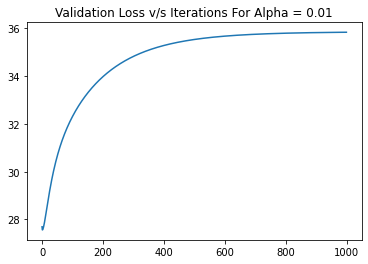



Alpha: 0.01, Iterations: 1000

For Validation Data
Accuracy:  0.7727272727272727
Precision:  0.5869565217391305
Recall:  0.627906976744186
F1 Score:  0.6067415730337079
Confusion Matrix
 [[27 19]
 [16 92]]


For Testing Data
Accuracy:  0.7922077922077922
Precision:  0.7777777777777778
Recall:  0.5384615384615384
F1 Score:  0.6363636363636364
Confusion Matrix
 [[14  4]
 [12 47]]


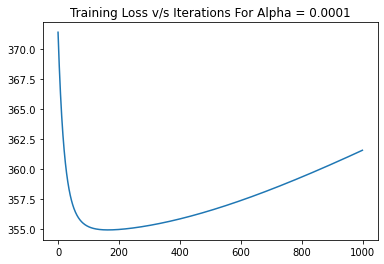

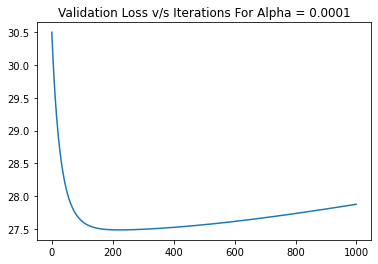



Alpha: 0.0001, Iterations: 1000

For Validation Data
Accuracy:  0.7337662337662337
Precision:  0.6
Recall:  0.13953488372093023
F1 Score:  0.22641509433962265
Confusion Matrix
 [[  6   4]
 [ 37 107]]


For Testing Data
Accuracy:  0.6883116883116883
Precision:  0.75
Recall:  0.11538461538461539
F1 Score:  0.2
Confusion Matrix
 [[ 3  1]
 [23 50]]


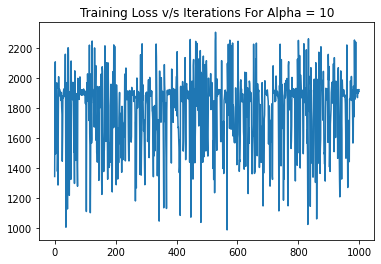

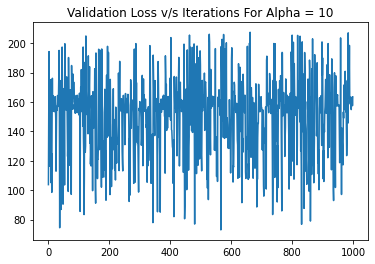



Alpha: 10, Iterations: 1000

For Validation Data
Accuracy:  0.6298701298701299
Precision:  0.4222222222222222
Recall:  0.8837209302325582
F1 Score:  0.5714285714285714
Confusion Matrix
 [[38 52]
 [ 5 59]]


For Testing Data
Accuracy:  0.7662337662337663
Precision:  0.5952380952380952
Recall:  0.9615384615384616
F1 Score:  0.7352941176470589
Confusion Matrix
 [[25 17]
 [ 1 34]]


In [ ]:
alpha = [0.01,0.0001,10]
for a in alpha:
  sgd = SGDLogisticRegression(a,1000)
  sgd.fit(X_train,y_train,X_val,y_val)
  sgd.plot()
  
  print("\n\nAlpha: "+str(a)+", Iterations: 1000\n")
  print("For Validation Data")
  y_pred_val_sgd = sgd.predict(X_val)
  metrics = ClassificationMetrics(y_val,y_pred_val_sgd)
  print("Accuracy: ",metrics.accuracy())
  print("Precision: ",metrics.precision())
  print("Recall: ",metrics.recall())
  print("F1 Score: ",metrics.f1_score())
  print("Confusion Matrix\n",metrics.confusion_matrix())


  y_pred_test_sgd = sgd.predict(X_test)
  metrics = ClassificationMetrics(y_test,y_pred_test_sgd)

  print("\n\nFor Testing Data")
  print("Accuracy: ",metrics.accuracy())
  print("Precision: ",metrics.precision())
  print("Recall: ",metrics.recall())
  print("F1 Score: ",metrics.f1_score())
  print("Confusion Matrix\n",metrics.confusion_matrix())
    

# 2

# Using Sklearn's Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train,y_train.ravel())
y_pred_val = logistic_regression.predict(X_val)
y_pred_test = logistic_regression.predict(X_test)

### Number of epochs to converge

In [ ]:
logistic_regression.n_iter_

array([16], dtype=int32)

### Peformance Comparison

In [ ]:
print("For Validation Data")
metrics = ClassificationMetrics(y_val,y_pred_val)
print("Accuracy: ",metrics.accuracy())
print("Precision: ",metrics.precision())
print("Recall: ",metrics.recall())
print("F1 Score: ",metrics.f1_score())
print("Confusion Matrix\n",metrics.confusion_matrix())


metrics = ClassificationMetrics(y_test,y_pred_test)
print("\n\nFor Testing Data")
print("Accuracy: ",metrics.accuracy())
print("Precision: ",metrics.precision())
print("Recall: ",metrics.recall())
print("F1 Score: ",metrics.f1_score())
print("Confusion Matrix\n",metrics.confusion_matrix())

For Validation Data
Accuracy:  0.7792207792207793
Precision:  0.6097560975609756
Recall:  0.5813953488372093
F1 Score:  0.5952380952380952
Confusion Matrix
 [[25 16]
 [18 95]]


For Testing Data
Accuracy:  0.7402597402597403
Precision:  0.6875
Recall:  0.4230769230769231
F1 Score:  0.5238095238095238
Confusion Matrix
 [[11  5]
 [15 46]]


In [ ]:
bgd = BGDLogisticRegression(0.01,16)
bgd.fit(X_train,y_train,X_val,y_val)

print("\n\nAlpha: 0.01, Iterations: 16\n")
print("For Validation Data")
y_pred_val_bgd = bgd.predict(X_val)
metrics = ClassificationMetrics(y_val,y_pred_val_bgd)
print("Accuracy: ",metrics.accuracy())
print("Precision: ",metrics.precision())
print("Recall: ",metrics.recall())
print("F1 Score: ",metrics.f1_score())
print("Confusion Matrix\n",metrics.confusion_matrix())


y_pred_test_bgd = bgd.predict(X_test)
metrics = ClassificationMetrics(y_test,y_pred_test_bgd)

print("\n\nFor Training Data")
print("Accuracy: ",metrics.accuracy())
print("Precision: ",metrics.precision())
print("Recall: ",metrics.recall())
print("F1 Score: ",metrics.f1_score())
print("Confusion Matrix\n",metrics.confusion_matrix())



Alpha: 0.01, Iterations: 16

For Validation Data
Accuracy:  0.7207792207792207
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
Confusion Matrix
 [[  0   0]
 [ 43 111]]


For Training Data
Accuracy:  0.6623376623376623
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
Confusion Matrix
 [[ 0  0]
 [26 51]]


In [ ]:
bgd = BGDLogisticRegression(0.01,40000)
bgd.fit(X_train,y_train,X_val,y_val)

print("\n\nAlpha: 0.01, Iterations: 40000\n")
print("For Validation Data")
y_pred_val_bgd = bgd.predict(X_val)
metrics = ClassificationMetrics(y_val,y_pred_val_bgd)
print("Accuracy: ",metrics.accuracy())
print("Precision: ",metrics.precision())
print("Recall: ",metrics.recall())
print("F1 Score: ",metrics.f1_score())
print("Confusion Matrix\n",metrics.confusion_matrix())


y_pred_test_bgd = bgd.predict(X_test)
metrics = ClassificationMetrics(y_test,y_pred_test_bgd)

print("\n\nFor Training Data")
print("Accuracy: ",metrics.accuracy())
print("Precision: ",metrics.precision())
print("Recall: ",metrics.recall())
print("F1 Score: ",metrics.f1_score())
print("Confusion Matrix\n",metrics.confusion_matrix())



Alpha: 0.01, Iterations: 40000

For Validation Data
Accuracy:  0.7662337662337663
Precision:  0.574468085106383
Recall:  0.627906976744186
F1 Score:  0.6
Confusion Matrix
 [[27 20]
 [16 91]]


For Training Data
Accuracy:  0.7792207792207793
Precision:  0.7368421052631579
Recall:  0.5384615384615384
F1 Score:  0.6222222222222222
Confusion Matrix
 [[14  5]
 [12 46]]
